In [243]:
import numpy as np

x_train = np.load("./data/LR/train_data.npy")
y_train = np.load("./data/LR/train_target.npy")
x_test = np.load("./data/LR/test_data.npy")
y_test = np.load("./data/LR/test_target.npy")

class LogitRegression:
    def __init__(self, x_train, y_train, alpha=0.2, epoch=-1, tol=1e-2, model='GD'):
        self.x_train = x_train
        self.y_train = y_train
        self.beta = np.ones(x_train.shape[1])
        self.alpha = alpha
        self.epoch = epoch
        self.tol = tol
        self.model = model
        
    def probability(self, x):
        return 1/(1+np.exp(-x @ self.beta))
    
    def loss_J(self):
        p = self.probability(self.x_train)
        return -np.sum([self.y_train[i] * np.log(p[i]) + (1-self.y_train[i]) * np.log(p[i])
                        for i in range(len(self.y_train))])
    
    @property
    def m(self):
        return len(self.y_train)
    
    @property
    def d(self):
        return self.x_train.shape[1]
    
    def train(self):
        # stop by tol
        loss = []
        if self.model == 'GD':
            if self.epoch == -1:
                while True:
                    grad = np.zeros(self.x_train.shape)
                    for i in range(self.m):
                        grad[i] = (1/(1+np.exp(-self.x_train[i] @ self.beta)) - self.y_train[i]) * self.x_train[i]
                    delta = self.alpha * grad.mean(axis=0)
                    self.beta -= delta
                    if np.abs(delta).mean() < self.tol:
                        break
                return

            # stop by epoch
            for _ in range(self.epoch):
                grad = np.zeros(self.x_train.shape)
                loss.append(self.loss_J())
                for i in range(self.m):
                    grad[i] = (1/(1+np.exp(-self.x_train[i] @ self.beta)) - self.y_train[i]) * self.x_train[i]
                self.beta -= self.alpha * grad.mean(axis=0)
            return loss
        elif self.model == 'SGD':
            # stop by epoch
            for _ in range(self.epoch):
                loss.append(self.loss_J())
                i = int(np.random.uniform(low=0, high=self.m-1, size=1))
                grad = (1/(1+np.exp(-self.x_train[i] @ self.beta)) - self.y_train[i]) * self.x_train[i]
                self.beta -= self.alpha * grad
            return loss
        elif self.model == 'newton':
            # stop by epoch
            for _ in range(self.epoch):
                loss.append(self.loss_J())
                for i in range(self.m):
                    expxbeta = np.exp(-self.x_train[i] @ self.beta)
                    grad = (1/(1+expxbeta) - self.y_train[i]) * self.x_train[i]
                    gradd = (1/(1+expxbeta)) * (1-(1/(1+expxbeta))) * self.x_train.T @ self.x_train + np.eye(self.d) * 0.001
                    self.beta -= self.alpha * np.linalg.inv(gradd) @ grad
            return loss
            
    def test(self, x_test, y_test):
        x_test = np.array(x_test)
        p = self.probability(x_test)
        acc = 1-np.sum(np.abs([float(round(i)) for i in lr.probability(x_test)] - y_test)) / len(y_test)
        return p, acc
    
    def get_xxyy(self, span):
        xx = np.linspace(*span, (span[1]-span[0])*100)
        yy = (-self.beta[0]-self.beta[1]*xx) / self.beta[2]
        return xx, yy

lr = LogitRegression(x_train, y_train, alpha=0.1, epoch=200, model='newton')
loss = lr.train()

print(lr.test(x_train, y_train)[1])
print(lr.test(x_test, y_test)[1])

<ipython-input-243-044147297436>:70: RuntimeWarning: overflow encountered in exp
  expxbeta = np.exp(-self.x_train[i] @ self.beta)
<ipython-input-243-044147297436>:19: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x @ self.beta))
<ipython-input-243-044147297436>:23: RuntimeWarning: divide by zero encountered in log
  return -np.sum([self.y_train[i] * np.log(p[i]) + (1-self.y_train[i]) * np.log(p[i])
<ipython-input-243-044147297436>:23: RuntimeWarning: invalid value encountered in multiply
  return -np.sum([self.y_train[i] * np.log(p[i]) + (1-self.y_train[i]) * np.log(p[i])


0.9714285714285714
0.9333333333333333


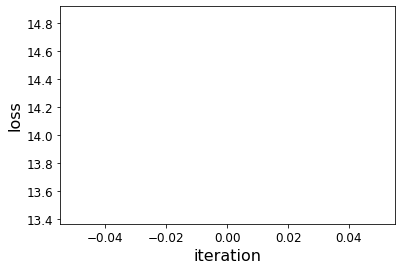

In [238]:
import matplotlib.pyplot as plt

plt.xlabel('iteration', size=16)
plt.ylabel('loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
xx = np.linspace(0, len(loss), len(loss))
plt.plot(xx, loss, c='green')

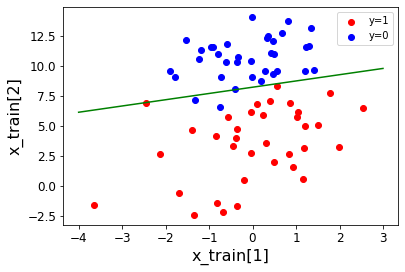

In [239]:
import matplotlib.pyplot as plt

xx, yy = lr.get_xxyy((-4, 3))
plt.xlabel('x_train[1]', size=16)
plt.ylabel('x_train[2]', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
red = np.where(y_train == 1)
blue = np.where(y_train == 0)
plt.scatter(x_train[red][:, 1], x_train[red][:, 2], c='red', label='y=1')
plt.scatter(x_train[blue][:, 1], x_train[blue][:,2], c='blue', label='y=0')
plt.legend()
plt.plot(xx, yy, c='green')

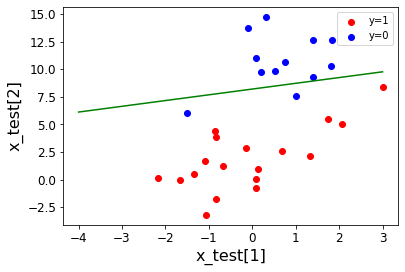

In [240]:
import matplotlib.pyplot as plt

xx, yy = lr.get_xxyy((-4, 3))
plt.xlabel('x_test[1]', size=16)
plt.ylabel('x_test[2]', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
red = np.where(y_test == 1)
blue = np.where(y_test == 0)
plt.scatter(x_test[red][:, 1], x_test[red][:, 2], c='red', label='y=1')
plt.scatter(x_test[blue][:, 1], x_test[blue][:,2], c='blue', label='y=0')
plt.legend()
plt.plot(xx, yy, c='green')

In [199]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=100, solver='newton-cg').fit(x_train, y_train)

print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

0.9571428571428572
0.9333333333333333
